
# MCP Bend (2D on XY) Under Palm Roll About X-Axis
**Goal:** Keep the bend defined in the XY plane and always **measure the bend from XY only**, while simulating a **palm roll** by rotating the entire hand about the **X-axis**. We then examine how this 3D rotation (which mixes Y and Z) perturbs the **XY-projected** bend measurement.

**Points:**
- **M** — MCP joint (the vertex of the angle)
- **H** — a top-of-hand reference point along the metacarpal direction
- **P** — PIP joint along the proximal phalanx

We construct **H** and **P** so that the **true bend angle θ_true** is purely in the XY plane.  
Then we rotate **all** points by **Rx(φ)** about the X-axis and **still** compute the bend from the XY projection only.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def angle_2d(u: np.ndarray, v: np.ndarray) -> float:
    """Angle (radians) between 2D vectors u and v."""
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu == 0 or nv == 0:
        return np.nan
    cosang = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return float(np.arccos(cosang))

def Rx(phi: float) -> np.ndarray:
    """Rotation about the X-axis by phi (radians)."""
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[1.0, 0.0, 0.0],
                     [0.0,  c, -s],
                     [0.0,  s,  c]])

def project_XY(points_3d: np.ndarray) -> np.ndarray:
    """Orthographic projection onto the XY-plane (drop Z)."""
    return points_3d[:, :2].copy()


## Configuration — bend defined in the XY plane

In [4]:

# Lengths (cm)
L_hand = 6.0   # M→H along +X (metacarpal reference)
L_prox = 5.0   # M→P in XY (proximal phalanx length)

# Height above table (just to have Z ≠ 0 initially)
z_height = 10.0

def make_points_xy_bend(theta_true_deg: float,
                        L_hand: float = 6.0,
                        L_prox: float = 5.0,
                        z_height: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return H, M, P in 3D with bend angle theta_true defined purely in XY."""
    theta = np.deg2rad(theta_true_deg)
    M = np.array([0.0, 0.0, z_height])
    # Reference direction (metacarpal) along +X
    H = np.array([L_hand, 0.0, z_height])
    # Proximal phalanx in XY plane at angle theta from +X
    P = np.array([L_prox*np.cos(theta), L_prox*np.sin(theta), z_height])
    return H, M, P

def bend_xy_deg(H: np.ndarray, M: np.ndarray, P: np.ndarray) -> float:
    """Compute bend angle from XY only (2D vectors MH and MP)."""
    v1 = (H - M)[:2]
    v2 = (P - M)[:2]
    return np.rad2deg(angle_2d(v1, v2))

def bend_after_xroll_xy_deg(H: np.ndarray, M: np.ndarray, P: np.ndarray, roll_x_deg: float) -> float:
    """Rotate all points about X-axis, project to XY, then compute 2D bend."""
    R = Rx(np.deg2rad(roll_x_deg))
    Hr, Mr, Pr = R @ H, R @ M, R @ P
    Hr2, Mr2, Pr2 = Hr[:2], Mr[:2], Pr[:2]
    return np.rad2deg(angle_2d(Hr2 - Mr2, Pr2 - Mr2))


## Sanity check (θ_true preserved at 0° roll)

In [45]:

theta_true = 90
H, M, P = make_points_xy_bend(theta_true)
theta_xy = bend_xy_deg(H, M, P)
theta_xy_roll0 = bend_after_xroll_xy_deg(H, M, P, 0.0)

print(f"θ_true (XY-only, no roll): {theta_xy:.2f}° | after X-roll 0°: {theta_xy_roll0:.2f}°")


θ_true (XY-only, no roll): 90.00° | after X-roll 0°: 90.00°


## Error vs. X-roll for a fixed bend angle (XY-only measurement)

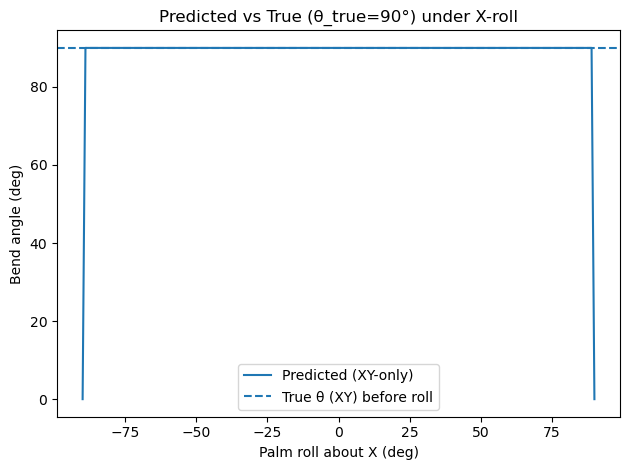

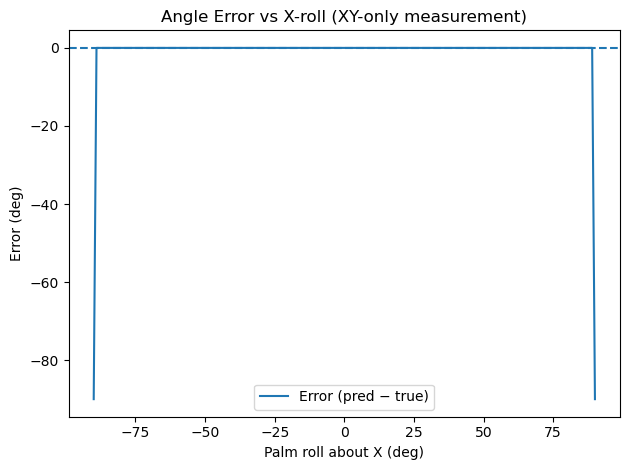

In [48]:

theta_true = 90
H, M, P = make_points_xy_bend(theta_true)

rolls = np.linspace(-90, 90, 181)
pred = np.array([bend_after_xroll_xy_deg(H, M, P, r) for r in rolls])
err = pred - theta_true

plt.figure()
plt.plot(rolls, pred, label='Predicted (XY-only)')
plt.axhline(theta_true, linestyle='--', label='True θ (XY) before roll')
plt.xlabel('Palm roll about X (deg)')
plt.ylabel('Bend angle (deg)')
plt.title(f'Predicted vs True (θ_true={theta_true}°) under X-roll')
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(rolls, err, label='Error (pred − true)')
plt.axhline(0, linestyle='--')
plt.xlabel('Palm roll about X (deg)')
plt.ylabel('Error (deg)')
plt.title('Angle Error vs X-roll (XY-only measurement)')
plt.legend()
plt.tight_layout()


## Heatmap: error(θ_true, X-roll) with XY-only measurement

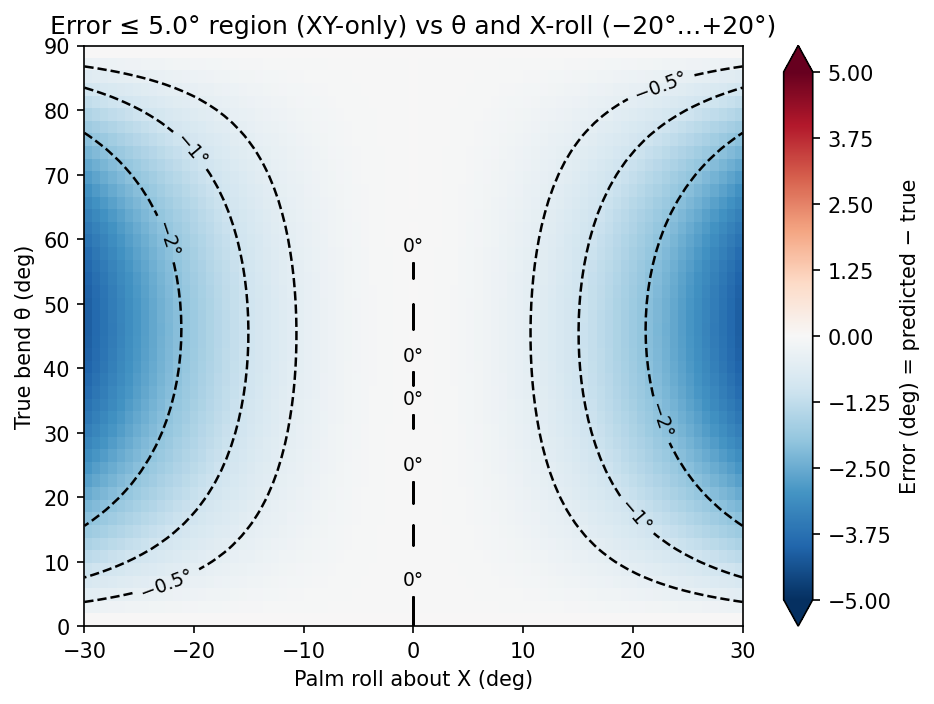

In [43]:
from matplotlib.colors import TwoSlopeNorm

thetas = np.linspace(0, 90, 46)     # 0..90 in 2° steps
rolls  = np.linspace(-30, 30, 81)   # -20..20 in 0.5° steps

ERR = np.empty((len(thetas), len(rolls)))
for i, t in enumerate(thetas):
    H, M, P = make_points_xy_bend(t)
    for j, r in enumerate(rolls):
        pred = bend_after_xroll_xy_deg(H, M, P, r)
        ERR[i, j] = pred - t

plt.figure(dpi=150)  # crisper gradients

# 1) Mask out errors with magnitude > 2°
tol = 5.0
mask = np.abs(ERR) <= tol
ERR_masked = np.ma.masked_where(~mask, ERR)

# 2) Diverging colormap centered at 0
cmap = plt.get_cmap('RdBu_r', 512).copy()
cmap.set_bad(alpha=0.0)
norm = TwoSlopeNorm(vmin=-tol, vcenter=0.0, vmax=tol)

# 3) Heatmap
im = plt.imshow(
    ERR_masked,
    extent=[rolls.min(), rolls.max(), thetas.min(), thetas.max()],
    origin='lower',
    aspect='auto',
    cmap=cmap,
    norm=norm
)

# Colorbar ticks suited for ±2°
ticks = np.linspace(-tol, tol, 9)  # [-2, -1.5, ..., 2]
cbar = plt.colorbar(im, ticks=ticks, label='Error (deg) = predicted − true', extend='both')

plt.xlabel('Palm roll about X (deg)')
plt.ylabel('True bend θ (deg)')
plt.title(f'Error ≤ {tol}° region (XY-only) vs θ and X-roll (−20°…+20°)')

# 4) Contours at 0.5°, 1°, 2° (±), plus 0° ridge
levels = [-2, -1, -0.5, 0, 0.5, 1, 2]
linestyles = ['--', '--', '--', '-', '-', '-', '--']  # 0° solid; others dashed
colors = 'k'

cs = plt.contour(
    rolls, thetas, ERR,
    levels=levels,
    linestyles=linestyles,
    colors=colors,
    linewidths=1.2
)

plt.clabel(cs, fmt={
    -2: '−2°', -1: '−1°', -0.5: '−0.5°',
     0: '0°',
     0.5: '+0.5°', 1: '+1°', 2: '+2°'
}, inline=True, fontsize=9)

plt.tight_layout()


## 3D visualization (optional)

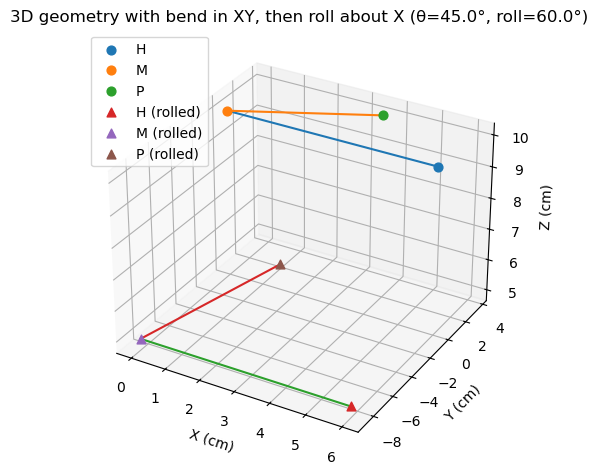

In [12]:

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

theta_demo = 45.0
roll_demo = 60.0

H, M, P = make_points_xy_bend(theta_demo)
R = Rx(np.deg2rad(roll_demo))
Hr, Mr, Pr = R @ H, R @ M, R @ P

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def draw_segment(a, b, **kw):
    ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], **kw)

# Original (before roll)
ax.scatter(*H, label='H', s=40)
ax.scatter(*M, label='M', s=40)
ax.scatter(*P, label='P', s=40)
draw_segment(M, H)
draw_segment(M, P)

# Rolled
ax.scatter(*Hr, label='H (rolled)', marker='^', s=40)
ax.scatter(*Mr, label='M (rolled)', marker='^', s=40)
ax.scatter(*Pr, label='P (rolled)', marker='^', s=40)
draw_segment(Mr, Hr)
draw_segment(Mr, Pr)

ax.set_title(f'3D geometry with bend in XY, then roll about X (θ={theta_demo}°, roll={roll_demo}°)')
ax.set_xlabel('X (cm)'); ax.set_ylabel('Y (cm)'); ax.set_zlabel('Z (cm)')
ax.legend()
plt.tight_layout()


3D bend pre/post: 90.0° / 90.0°  (unchanged)
XY length (MCP→PIP) pre/post: 3.000 / 0.000


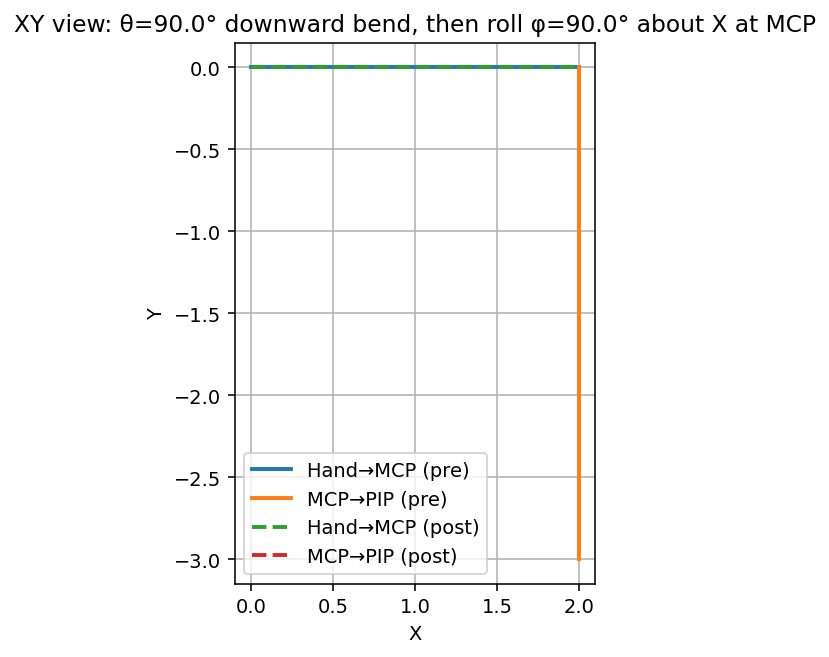

In [52]:
import numpy as np
import matplotlib.pyplot as plt

L_hand = 2.0     # Hand→MCP (on +X)
L_prox = 3.0     # MCP→PIP
theta_deg = 90.0 # downward bend in XY (negative Y)
phi_deg   = 90.0 # roll about X through MCP

def Rx(a):
    c, s = np.cos(a), np.sin(a)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def rot_about_point(R, p, origin):
    return origin + R @ (p - origin)

def angle_between(u, v):
    un = u / (np.linalg.norm(u) + 1e-12)
    vn = v / (np.linalg.norm(v) + 1e-12)
    return np.degrees(np.arccos(np.clip(un @ vn, -1.0, 1.0)))

# Pre-roll geometry
H   = np.array([0.0, 0.0, 0.0])
MCP = np.array([L_hand, 0.0, 0.0])

theta = np.radians(theta_deg)
u_prox_dir = np.array([np.cos(theta), -np.sin(theta), 0.0])  # downward in Y
PIP = MCP + L_prox * u_prox_dir

# Roll about X through MCP
R = Rx(np.radians(phi_deg))
H_r   = rot_about_point(R, H, MCP)
MCP_r = MCP.copy()
PIP_r = rot_about_point(R, PIP, MCP)

# Diagnostics
bend_3d_pre  = angle_between(MCP - H, PIP - MCP)
bend_3d_post = angle_between(MCP_r - H_r, PIP_r - MCP_r)
print(f"3D bend pre/post: {bend_3d_pre:.1f}° / {bend_3d_post:.1f}°  (unchanged)")
print(f"XY length (MCP→PIP) pre/post: "
      f"{np.linalg.norm((PIP-MCP)[:2]):.3f} / {np.linalg.norm((PIP_r-MCP_r)[:2]):.3f}")

# Plot XY
plt.figure(dpi=140)
plt.plot([H[0], MCP[0]],   [H[1], MCP[1]],   lw=2, label="Hand→MCP (pre)")
plt.plot([MCP[0], PIP[0]], [MCP[1], PIP[1]], lw=2, label="MCP→PIP (pre)")
plt.plot([H_r[0], MCP_r[0]],   [H_r[1], MCP_r[1]],   '--', lw=2, label="Hand→MCP (post)")
plt.plot([MCP_r[0], PIP_r[0]], [MCP_r[1], PIP_r[1]], '--', lw=2, label="MCP→PIP (post)")
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"XY view: θ={theta_deg}° downward bend, then roll φ={phi_deg}° about X at MCP")
plt.xlabel("X"); plt.ylabel("Y"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


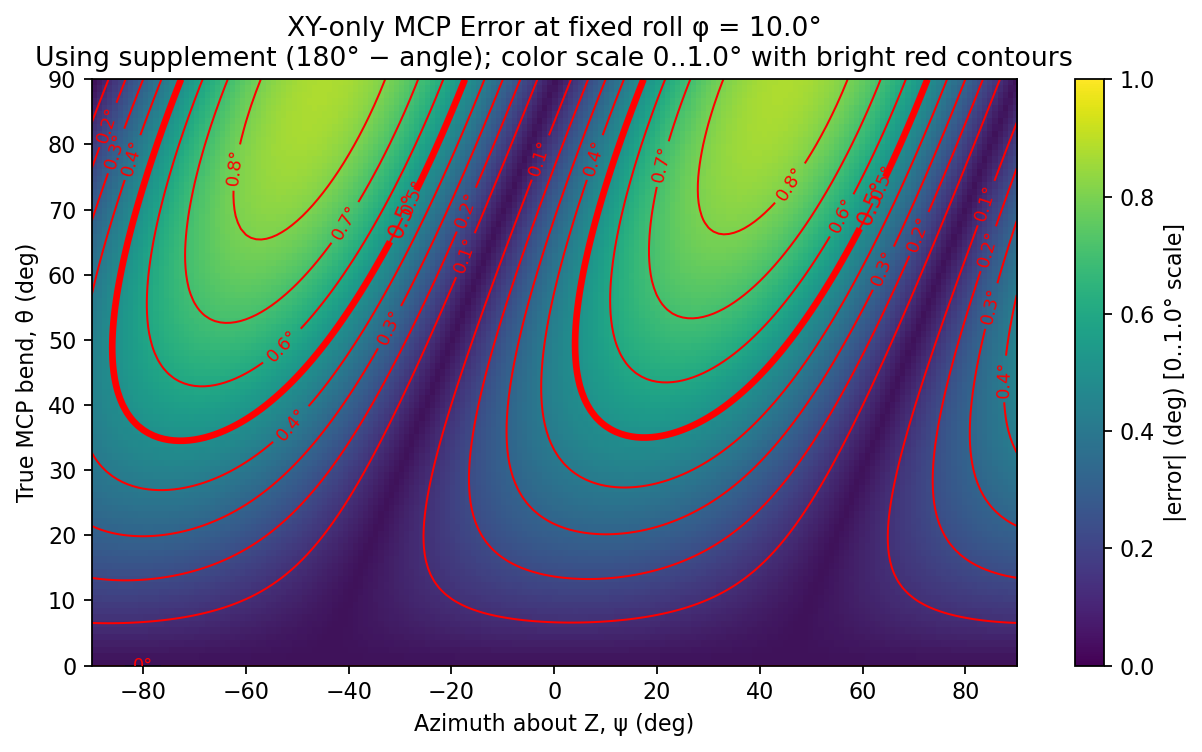

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def Rx(phi_deg):
    a = np.deg2rad(phi_deg); c, s = np.cos(a), np.sin(a)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def Rz(psi_deg):
    a = np.deg2rad(psi_deg); c, s = np.cos(a), np.sin(a)
    return np.array([[c,-s,0],[s,c,0],[0,0,1]], float)

def make_points_xy_bend(theta_deg, L_hand=2.0, L_prox=3.0):
    H = np.array([0.0, 0.0, 0.0])
    M = np.array([L_hand, 0.0, 0.0])
    th = np.deg2rad(theta_deg)
    P = M + np.array([L_prox*np.cos(th), -L_prox*np.sin(th), 0.0])
    return H, M, P

def mcp_angle_xy_only(H, M, P, use_supplement=True):
    v1 = H - M; v2 = P - M
    v1_xy = v1[:2]; v2_xy = v2[:2]
    n1 = np.linalg.norm(v1_xy); n2 = np.linalg.norm(v2_xy)
    if n1 == 0 or n2 == 0: return np.nan
    cross = v1_xy[0]*v2_xy[1] - v1_xy[1]*v2_xy[0]
    dot   = v1_xy @ v2_xy
    ang = np.rad2deg(np.abs(np.arctan2(cross, dot)))  # 0..180
    return (180.0 - ang) if use_supplement else ang

def plot_heatmap_focus_0to1(roll_fixed=10.0, vmax=1.0,
                            L_hand=2.0, L_prox=3.0, savepath=None,
                            use_supplement=True):
    thetas = np.arange(0.0, 90.0 + 1.0, 1.0)
    psis   = np.arange(-90.0, 90.0 + 1.0, 1.0)
    ERR = np.zeros((len(thetas), len(psis)), float)

    Rx_fixed = Rx(roll_fixed)
    for j, psi in enumerate(psis):
        R = Rx_fixed @ Rz(psi)
        for i, th in enumerate(thetas):
            H, M, P = make_points_xy_bend(th, L_hand=L_hand, L_prox=L_prox)
            Hr, Mr, Pr = R @ H, R @ M, R @ P
            pred = mcp_angle_xy_only(Hr, Mr, Pr, use_supplement=use_supplement)
            ERR[i, j] = abs(pred - th)

    extent = [psis.min(), psis.max(), thetas.min(), thetas.max()]
    plt.figure(figsize=(8, 4.8), dpi=160)

    im = plt.imshow(np.clip(ERR, 0, vmax), origin='lower', extent=extent,
                    aspect='auto', vmin=0, vmax=vmax)
    plt.colorbar(im, label=f'|error| (deg) [0..{vmax}° scale]')

    low_mask = np.ma.masked_greater(ERR, 0.5)
    plt.contourf(psis, thetas, low_mask, levels=[0, 0.5], alpha=0.12)

    levels_fine = np.arange(0.0, min(vmax, 1.0) + 0.1, 0.1)  # 0..1 by 0.1
    cs_all = plt.contour(psis, thetas, ERR, levels=levels_fine, linewidths=0.9, colors='red')
    plt.clabel(cs_all, inline=True, fontsize=8, fmt='%g°')

    def emphasize(level, lw=2.6, ls='-'):
        cs = plt.contour(psis, thetas, ERR, levels=[level], linewidths=lw, linestyles=ls, colors='red')
        if len(cs.allsegs[0]) > 0:
            plt.clabel(cs, inline=True, fontsize=10, fmt='%g°')
        return cs
    emphasize(0.5, lw=3.0, ls='-')
    emphasize(1.0, lw=2.4, ls='--')

    mode = "supplement (180° − angle)" if use_supplement else "direct angle"
    plt.xlabel('Azimuth about Z, ψ (deg)')
    plt.ylabel('True MCP bend, θ (deg)')
    plt.title(f'XY-only MCP Error at fixed roll φ = {roll_fixed:.1f}°\n'
              f'Using {mode}; color scale 0..{vmax}° with bright red contours')
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=160)
    plt.show()
    return ERR

# Example: focus 0..1°
ERR_10 = plot_heatmap_focus_0to1(roll_fixed=10.0, vmax=1.0, use_supplement=True)

# If you want 0..0.5° instead:
# ERR_10_half = plot_heatmap_focus_0to1(roll_fixed=10.0, vmax=0.5, use_supplement=True)


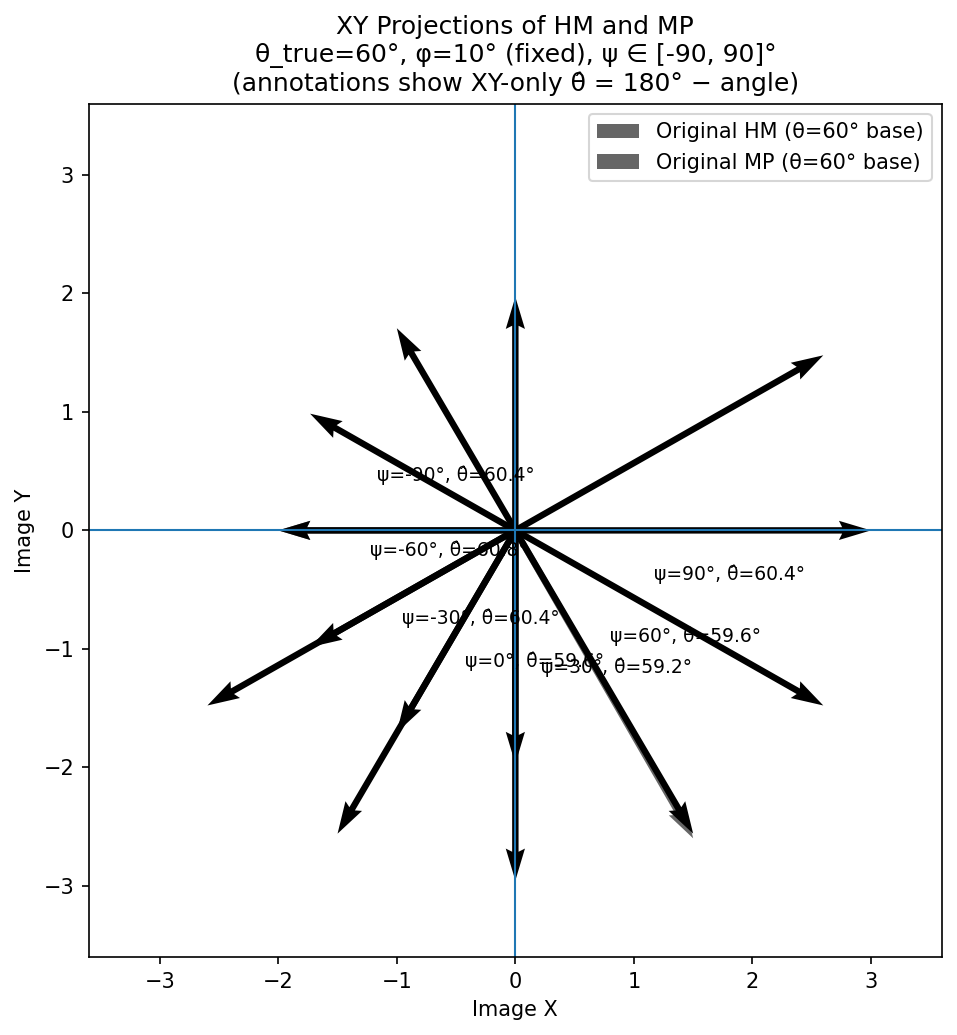

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Config ----
theta_true = 60.0                 # true bend (deg)
roll_fixed = 10.0                 # fixed roll about X (deg)
psis_to_show = np.arange(-90, 91, 30)   # azimuths about Z (deg): -90..90 step 30
L_hand, L_prox = 2.0, 3.0

# ---- Helpers ----
def Rx(phi_deg):
    a = np.deg2rad(phi_deg); c, s = np.cos(a), np.sin(a)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def Rz(psi_deg):
    a = np.deg2rad(psi_deg); c, s = np.cos(a), np.sin(a)
    return np.array([[c,-s,0],[s,c,0],[0,0,1]], float)

def make_points_xy_bend(theta_deg):
    H = np.array([0.,0.,0.])
    M = np.array([L_hand,0.,0.])
    th = np.deg2rad(theta_deg)
    P = M + np.array([L_prox*np.cos(th), -L_prox*np.sin(th), 0.])
    return H, M, P

def mcp_angle_xy_only_supplement(H, M, P):
    """XY-projection angle between HM and MP, then return 180° - angle."""
    v1 = (H - M)[:2]
    v2 = (P - M)[:2]
    cross = v1[0]*v2[1] - v1[1]*v2[0]
    dot   = v1 @ v2
    ang_xy = np.rad2deg(np.abs(np.arctan2(cross, dot)))  # 0..180
    return 180.0 - ang_xy

# Base points (no rotations)
H0, M0, P0 = make_points_xy_bend(theta_true)

def get_xy_vectors_for(phi_deg, psi_deg):
    # Apply azimuth (about Z) BEFORE roll (about X):
    R = Rx(phi_deg) @ Rz(psi_deg)
    H, M, P = R @ H0, R @ M0, R @ P0
    u_xy = (H - M)[:2]   # HM in XY
    v_xy = (P - M)[:2]   # MP in XY
    pred = mcp_angle_xy_only_supplement(H, M, P)
    return u_xy, v_xy, pred

# ---- Plot ----
plt.figure(figsize=(7,7), dpi=150)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Original (no Z or X rotation) for reference
u0 = (H0 - M0)[:2]; v0 = (P0 - M0)[:2]
ax.quiver(0,0, *u0, angles='xy', scale_units='xy', scale=1, alpha=0.6, linewidth=2, label=f'Original HM (θ={theta_true:.0f}° base)')
ax.quiver(0,0, *v0, angles='xy', scale_units='xy', scale=1, alpha=0.6, linewidth=2, label=f'Original MP (θ={theta_true:.0f}° base)')

# Azimuth sweep at fixed roll
for psi in psis_to_show:
    u_xy, v_xy, pred = get_xy_vectors_for(roll_fixed, psi)
    ax.quiver(0,0, *u_xy, angles='xy', scale_units='xy', scale=1, linewidth=2)
    ax.quiver(0,0, *v_xy, angles='xy', scale_units='xy', scale=1, linewidth=2)
    ax.text(u_xy[0]*0.55 + v_xy[0]*0.45, u_xy[1]*0.55 + v_xy[1]*0.45,
            f'ψ={psi:g}°, θ̂={pred:.1f}°', fontsize=9)

# Axes & limits
ax.axhline(0, linewidth=1); ax.axvline(0, linewidth=1)
ax.set_xlabel('Image X'); ax.set_ylabel('Image Y')
ax.set_title(
    f'XY Projections of HM and MP\nθ_true={theta_true:.0f}°, φ={roll_fixed:g}° (fixed), ψ ∈ [{psis_to_show.min()}, {psis_to_show.max()}]°\n'
    '(annotations show XY-only θ̂ = 180° − angle)'
)
ax.legend(loc='upper right')

# Limits with margin
all_vecs = [u0, v0]
for psi in psis_to_show:
    u_xy, v_xy, _ = get_xy_vectors_for(roll_fixed, psi)
    all_vecs += [u_xy, v_xy]
V = np.vstack(all_vecs); lim = np.max(np.abs(V)) * 1.2
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
plt.tight_layout(); plt.show()


In [9]:
import numpy as np

# ---------- Rotations ----------
def Rx(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c,-s],
                     [0, s, c]])

def Rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c,-s, 0],
                     [ s, c, 0],
                     [ 0, 0, 1]])

# ---------- Geometry (M→H backward, M→P forward at theta in XY) ----------
def make_points_xy_bend_backward(theta_true_deg: float,
                                 L_hand: float = 6.0,
                                 L_prox: float = 5.0,
                                 z_height: float = 10.0):
    """
    Returns H, M, P with:
      M at (0,0,z), M→H along −X (toward wrist), M→P at theta from +X in XY.
    """
    th = np.deg2rad(theta_true_deg)
    M = np.array([0.0, 0.0, z_height])
    H = np.array([-L_hand, 0.0, z_height])  # backward
    P = np.array([L_prox*np.cos(th), L_prox*np.sin(th), z_height])
    return H, M, P

# ---------- Angle helpers ----------
def angle_between_3d(a, b):
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return np.nan
    cosang = np.clip(np.dot(a, b) / (na * nb), -1.0, 1.0)
    return float(np.degrees(np.arccos(cosang)))

def bend_3d_deg(H: np.ndarray, M: np.ndarray, P: np.ndarray) -> float:
    """True 3D bend between M→H and M→P using XYZ vectors."""
    v1 = H - M
    v2 = P - M
    return angle_between_3d(v1, v2)

def bend_xy_unsigned_deg(H: np.ndarray, M: np.ndarray, P: np.ndarray) -> float:
    """XY-only bend (unsigned, [0,180]), by projecting M→H and M→P to XY."""
    v1 = (H - M)[:2]
    v2 = (P - M)[:2]
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 == 0 or n2 == 0:
        return np.nan
    c = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return float(np.degrees(np.arccos(c)))

def bend_xy_signed_deg(H: np.ndarray, M: np.ndarray, P: np.ndarray) -> float:
    """Signed XY bend (−180..180], CCW positive from M→H to M→P after XY projection."""
    v1 = (H - M)[:2]
    v2 = (P - M)[:2]
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 == 0 or n2 == 0:
        return np.nan
    cross_z = v1[0]*v2[1] - v1[1]*v2[0]
    dot = np.dot(v1, v2)
    return float(np.degrees(np.arctan2(cross_z, dot)))

# ---------- Unrotate about Z (remove global yaw) ----------
def unrotate_z_and_bend_xy_deg(H: np.ndarray, M: np.ndarray, P: np.ndarray,
                               signed: bool = False,
                               reference: str = 'MH') -> float:
    """
    Remove global yaw by rotating both vectors about Z so the reference vector has zero yaw.
      reference='MH' uses M→H to define yaw (typical),
      reference='MP' uses M→P.
    Returns the XY bend after this unrotation (signed or unsigned).
    """
    if reference not in ('MH', 'MP'):
        raise ValueError("reference must be 'MH' or 'MP'")
    v1 = H - M
    v2 = P - M
    ref = v1 if reference == 'MH' else v2
    # Yaw angle of reference in XY
    phi = np.arctan2(ref[1], ref[0])
    # Rotate both XY vectors by -phi (equivalent to Rz(-phi) then XY projection)
    c, s = np.cos(-phi), np.sin(-phi)
    R2 = np.array([[c, -s],
                   [s,  c]])
    v1_xy_un = R2 @ v1[:2]
    v2_xy_un = R2 @ v2[:2]

    n1 = np.linalg.norm(v1_xy_un); n2 = np.linalg.norm(v2_xy_un)
    if n1 == 0 or n2 == 0:
        return np.nan
    if signed:
        cross_z = v1_xy_un[0]*v2_xy_un[1] - v1_xy_un[1]*v2_xy_un[0]
        dot = np.dot(v1_xy_un, v2_xy_un)
        return float(np.degrees(np.arctan2(cross_z, dot)))
    else:
        cang = np.clip(np.dot(v1_xy_un, v2_xy_un) / (n1 * n2), -1.0, 1.0)
        return float(np.degrees(np.arccos(cang)))

# ---------- Example usage ----------
if __name__ == "__main__":
    # lengths and pose
    L_hand, L_prox, z_height = 6.0, 5.0, 10.0
    theta_true_deg = 40.0           # M→P angle from +X in XY
    yaw_z_deg, roll_x_deg = 30.0, 20.0

    # initial points (no out-of-plane)
    H0, M0, P0 = make_points_xy_bend_backward(theta_true_deg, L_hand, L_prox, z_height)

    # rotate whole scene: Z then X
    R = Rx(np.deg2rad(roll_x_deg)) @ Rz(np.deg2rad(yaw_z_deg))
    H1, M1, P1 = R @ H0, R @ M0, R @ P0

    # ---- 1) True 3D bend (XYZ) ----
    bend3d_init = bend_3d_deg(H0, M0, P0)
    bend3d_rot  = bend_3d_deg(H1, M1, P1)

    # ---- 2) XY-only bend ----
    bendxy_init_unsigned = bend_xy_unsigned_deg(H0, M0, P0)
    bendxy_rot_unsigned  = bend_xy_unsigned_deg(H1, M1, P1)

    # (optionally signed)
    bendxy_init_signed = bend_xy_signed_deg(H0, M0, P0)
    bendxy_rot_signed  = bend_xy_signed_deg(H1, M1, P1)

    # ---- 3) Unrotate about Z (remove yaw) then XY bend ----
    # Using M→H as the reference (common choice)
    bendxy_unrot_init = unrotate_z_and_bend_xy_deg(H0, M0, P0, signed=False, reference='MH')
    bendxy_unrot_rot  = unrotate_z_and_bend_xy_deg(H1, M1, P1, signed=False, reference='MH')

    print(f"True 3D bend (init, rot): {bend3d_init:.3f}°, {bend3d_rot:.3f}°")
    print(f"XY bend unsigned (init, rot): {bendxy_init_unsigned:.3f}°, {bendxy_rot_unsigned:.3f}°")
    print(f"XY bend signed   (init, rot): {bendxy_init_signed:.3f}°, {bendxy_rot_signed:.3f}°")
    print(f"XY bend after unrot. Z (ref=MH) (init, rot): {bendxy_unrot_init:.3f}°, {bendxy_unrot_rot:.3f}°")


True 3D bend (init, rot): 140.000°, 140.000°
XY bend unsigned (init, rot): 140.000°, 139.654°
XY bend signed   (init, rot): -140.000°, -139.654°
XY bend after unrot. Z (ref=MH) (init, rot): 140.000°, 139.654°
